### Import necessary packages

In [46]:
# Install required packages here if needed (remove '#')
#!pip3 install pandas
#!pip3 install pandas_datareader
#!pip3 install datetime
#!pip3 install yfinance
#!pip3 install getFamaFrenchFactors
#!pip3 install git+https://github.com/statsmodels/statsmodels
#!pip3 install scipy

### Functions to import price data

In [47]:
import pandas as pd
import pandas_datareader as web
import datetime

In [48]:
def read_price_data(stock_symbol, start_date, end_date, interval):
    """Import price data from Yahoo Finance"""
    try:
        stock_data = web.get_data_yahoo(stock_symbol, start_date, end_date, interval=interval)
    except:
        return None

    prices = stock_data.loc[:, "Adj Close"]
    prices = prices.fillna(method="ffill")

    return prices

In [49]:
def get_date_list(stock_symbol, start_date, end_date, interval):
    """Generate list of trading dates"""
    stock_data = web.get_data_yahoo(stock_symbol, start_date, end_date, interval=interval)
    dates = stock_data.index
    
    return dates

### Generate input table

### Example of mathematical notation using LaTeX syntax
CAPM: $\mathbb{E}(R_i)=R_f+\beta_i (\mathbb{E}(R_m)-R_f)$ 

Enter stock symbol: MSFT
interval is monthly
enter startdate according to the following pattern year-month-day2021-09-01
enter enddate according to the following pattern year-month-day2022-09-01
Date
2022-09-01    245.380005
2022-08-01    260.916168
2022-07-01    280.145355
2022-06-01    256.285980
2022-05-01    270.663727
2022-04-01    276.288666
2022-03-01    306.942047
2022-02-01    296.850494
2022-01-01    308.961395
2021-12-01    334.136932
2021-11-01    327.844299
2021-10-01    328.865723
2021-09-01    279.578522
Name: Stock price (MSFT), dtype: float64
Date
2022-09-01    3901.350098
2022-08-01    3955.000000
2022-07-01    4130.290039
2022-06-01    3785.379883
2022-05-01    4132.149902
2022-04-01    4131.930176
2022-03-01    4530.410156
2022-02-01    4373.939941
2022-01-01    4515.549805
2021-12-01    4766.180176
2021-11-01    4567.000000
2021-10-01    4605.379883
2021-09-01    4307.540039
Name: Index price (^GSPC), dtype: float64
return stock :  0.13936961514869764
return index 

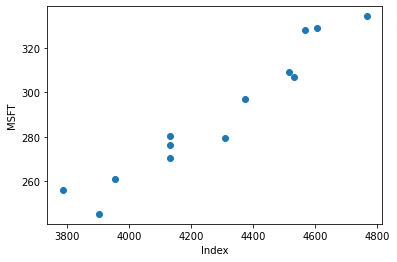

In [50]:
import yfinance as yh
import matplotlib.pyplot as plt
import getFamaFrenchFactors as gff
from scipy.stats import pearsonr
from datetime import datetime

#CHOOSE STOCK AND INDEX
stock = input("Enter stock symbol: ")
#DEFAULT INDEX SP500 = ticker ^GSPC
index_symbol = "^GSPC"

#!!CHOOSE DATES
print("interval is monthly")
startDate = input("enter startdate according to the following pattern year-month-day")
endDate = input("enter enddate according to the following pattern year-month-day")

start_date = datetime.strptime(startDate, '%Y-%m-%d').date()
end_date = datetime.strptime(endDate, '%Y-%m-%d').date()


interval = 'm' # Date interval, by default daily ('d')
date_list = get_date_list(index_symbol, start_date, end_date, interval=interval)

# Generate empty dataframe
column_header_index = "Index price ({})".format(index_symbol)
column_header_stock = "Stock price ({})".format(stock)
df = pd.DataFrame(
        columns=[column_header_index, column_header_stock], index=date_list
    )

# Sort dataframe based on date
df = df.sort_index(ascending=False)  

# Import price series into dataframe
try:
    price_series = read_price_data(index_symbol, start_date, end_date, interval=interval)
    df[column_header_index] = price_series
    
    price_series = read_price_data(stock, start_date, end_date, interval=interval)
    df[column_header_stock] = price_series  
except:
    print('Import failed')

# Print dataframe
print(df[column_header_stock])
print(df[column_header_index])
#calculate average return over period for the ticker
firstValueStock = df[column_header_stock].iloc[0]
lastValueStock = df[column_header_stock].iloc[-1]
returnTicker = (lastValueStock - firstValueStock)/firstValueStock
print("return stock : ", returnTicker)

#calculate average return over period for the index
firstValueIndex = df[column_header_index].iloc[0]
lastValueIndex = df[column_header_index].iloc[-1]
returnIndex = (lastValueIndex - firstValueIndex)/firstValueIndex
print("return index : ", returnIndex)

#get beta of the respective ticker
dataTicker = yh.Ticker(stock)
beta = dataTicker.info['beta']
print("beta for ", stock, " : ", beta)

#now calculate risk free rate
#we calculate the risk free rate by using the Fama French three factor model's inplementation in python

dataCompany = yh.download(stock, start=startDate,end= endDate);

stockPrices = dataCompany['Adj Close'];
stockPrices = stockPrices.resample("1M").last();
assetReturn = stockPrices.pct_change();
assetReturn = assetReturn.dropna();
assetReturn.name = "Asset";

ff3_monthly = pd.DataFrame(gff.famaFrench3Factor(frequency='m'))
ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
ff_data = ff3_monthly.merge(assetReturn, on='Date')
rf = ff_data['RF'].mean()
print("rf ",rf)

#calculate the capm
capm = rf + (beta * (returnIndex - rf))
#ouput the calculated capm
print(" Capm for ", stock ," : " ,capm)
#calcualte and output R2
corr, _ = pearsonr(df[column_header_index], df[column_header_stock])
RSquared = corr * corr;
print("R^2 for ", stock, " : " , RSquared)
#output scatterplot

x=df[column_header_index]
y=df[column_header_stock]
plt.scatter(x, y, marker='o')
plt.xlabel('Index')
plt.ylabel(stock)
plt.show()